In [1]:
import json
from time import sleep, time
from functions import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
rm = pyvisa.ResourceManager()
lr = rm.list_resources()
for r in lr:
    if "awg" in r:
        AWG = ArbitraryWaveformGenerator(r)
    elif "daq" in r:
        DAQ = DataAcquisition(r)
    elif "172.31.182.32" in r:
        SMU = SourceMeasureUnit(r)
    elif "osc" in r:
        OSC = Oscilloscope(r)

In [4]:
AWG.connect()
DAQ.connect()
SMU.connect()
OSC.connect()

In [5]:
#AWG.reset()
#SMU.reset()
#DAQ.reset()
#OSC.reset()

In [6]:
OSC.write("SYST:DISP:UPD 1")
DAQ.set_conn(123)

In [7]:
wf_dict_AWG = {
    'V' : [1, -.5], # pulse voltages
    'n' : [5, 2],   # pulse repetitions
    'T' : 2e-5,     # pulse period
    'W' : 1e-6,     # pulse width
    'read' : True,
    'read_V' : .1
}
ch_AWG = 1
get_and_set_wf(AWG, ch_AWG, wf_dict_AWG)

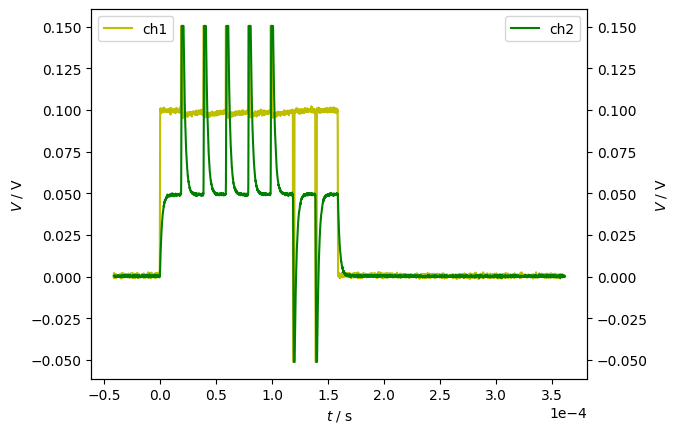

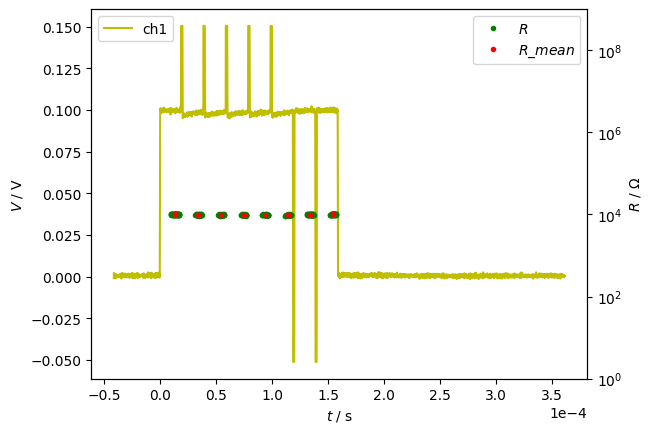

In [8]:
wf, R, valid = meas_AWG(DAQ, 113, AWG, ch_AWG, wf_dict_AWG, OSC, [1, 2])

In [9]:
meas_AWG_dict = {
    **wf_dict_AWG,
    'ch' : ch_AWG,
    'wf_OSC' : [wf[i].tolist() for i in range(2)],
    'R_valid' : R[valid].tolist(),
    'valid' : valid.tolist()
}
with open("meas_AWG_dict.json", "w") as json_file:
    json_file.write(json.dumps(meas_AWG_dict))
with open("meas_AWG_dict.json", "r") as json_file:
    meas_AWG_dict = json.load(json_file)

In [10]:
wf_dict_SMU = {
    'V' : [1, .5],
    'n' : [2, 2],
    'T' : 1e-2,
    'W' : 1e-3,
    'read' : True,
    'read_V' : .1
}
ch_SMU = 1
get_and_set_wf(SMU, ch_SMU, wf_dict_SMU)

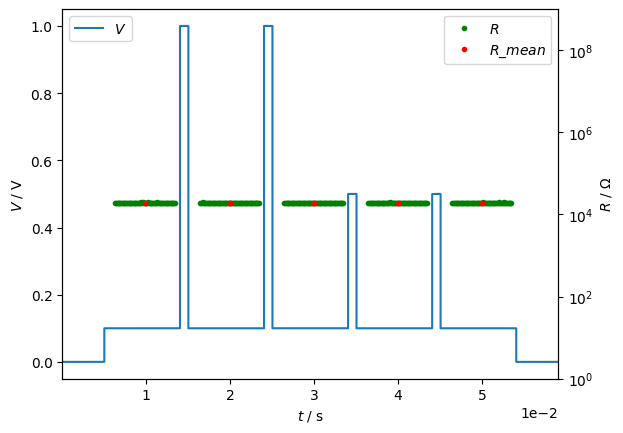

In [11]:
t, V_i, I_o, R, valid = meas_SMU(DAQ, 111, SMU, ch_SMU, wf_dict_SMU, OSC, [1, 2])

In [12]:
meas_SMU_dict = {
    **wf_dict_SMU,
    'ch' : ch_SMU,
    't' : t.tolist(),
    'V_i' : V_i.tolist(),
    'I_o' : I_o.tolist(),
    'R_valid' : R[valid].tolist(),
    'valid' : valid.tolist()
}
with open("meas_SMU_dict.json", "w") as json_file:
    json_file.write(json.dumps(meas_SMU_dict))
with open("meas_SMU_dict.json", "r") as json_file:
    meas_SMU_dict = json.load(json_file)

In [13]:
wf_dict_AWG = {
    'V' : [1],
    'n' : [1],
    'T' : 1e-4,
    'W' : 1e-5,
    'read' : False,
    'read_V' : .1
}
ch_AWG = 1
get_and_set_wf(AWG, ch_AWG, wf_dict_AWG)

In [14]:
wf_dict_SMU = {
    'V' : [1],
    'n' : [0],
    'T' : 1,
    'W' : 0,
    'read' : True,
    'read_V' : .1
}
ch_SMU = 1
get_and_set_wf(SMU, ch_SMU, wf_dict_SMU, aint=True)

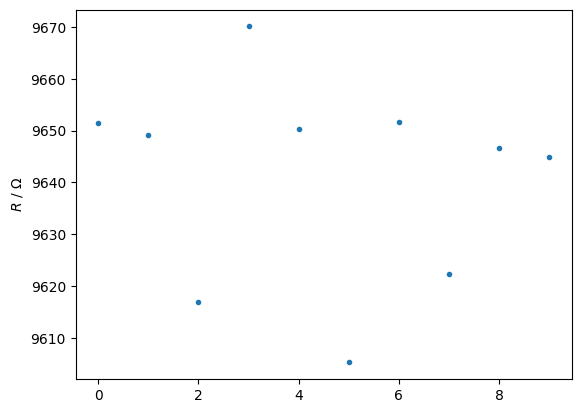

In [15]:
N = 10
R = meas_AWG_SMU(N, DAQ, AWG, ch_AWG, SMU, ch_SMU, wf_dict_SMU)